#**Code by Joshua Nichols (gustynewguy2214)**

##Import the needed libraries and mount Google Drive.

In [ ]:
import math
import numpy as np
import pandas as pd
import random as rng

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


##Load the data

In [ ]:
location = '/content/drive/My Drive/Colab Notebooks/input/'
assignment = '4611_HW_4'

original_train = pd.read_csv(location + assignment + '/train.csv')
original_test = pd.read_csv(location + assignment + '/test.csv')
sample_sub = pd.read_csv(location + assignment + '/sample_submission.csv')

train = original_train.copy().drop(columns=['id'])
test = original_test.copy().drop(columns=['id'])

##Inspect the data

In [ ]:
train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.22,37.77,40.0,494.0,114.0,547.0,135.0,2.8015,NEAR BAY,114800.0
1,-122.29,37.76,18.0,2873.0,763.0,1243.0,663.0,5.1702,NEAR BAY,265400.0
2,-118.48,34.23,29.0,3354.0,707.0,1752.0,650.0,4.5484,<1H OCEAN,239900.0
3,-122.19,37.80,48.0,1694.0,259.0,610.0,238.0,4.7440,NEAR BAY,257300.0
4,-121.93,36.63,33.0,1740.0,342.0,638.0,329.0,3.1912,NEAR OCEAN,319800.0
...,...,...,...,...,...,...,...,...,...,...
10315,-117.79,33.70,16.0,1416.0,249.0,636.0,244.0,5.1741,<1H OCEAN,227700.0
10316,-117.41,33.95,37.0,1586.0,283.0,675.0,305.0,2.9583,INLAND,132100.0
10317,-118.65,34.20,23.0,7480.0,1084.0,3037.0,1058.0,6.9223,<1H OCEAN,338400.0
10318,-118.00,34.12,37.0,1340.0,325.0,928.0,333.0,3.9219,INLAND,175000.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           10320 non-null  float64
 1   latitude            10320 non-null  float64
 2   housing_median_age  10320 non-null  float64
 3   total_rooms         10320 non-null  float64
 4   total_bedrooms      10210 non-null  float64
 5   population          10320 non-null  float64
 6   households          10320 non-null  float64
 7   median_income       10320 non-null  float64
 8   ocean_proximity     10320 non-null  object 
 9   median_house_value  10320 non-null  float64
dtypes: float64(9), object(1)
memory usage: 806.4+ KB


In [ ]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,10320.000000,10320.000000,10320.000000,10320.000000,10210.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,-119.593791,35.647997,28.544477,2652.874031,541.297845,1431.618120,502.993605,3.882051,208222.779845
std,2.005209,2.132319,12.605356,2215.969393,427.866565,1144.035957,388.016806,1.902330,116152.666840
min,-124.350000,32.540000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.810000,33.940000,18.000000,1461.000000,294.250000,786.000000,278.000000,2.583300,120000.000000
50%,-118.535000,34.270000,29.000000,2138.000000,438.000000,1165.000000,413.000000,3.550000,180700.000000
75%,-118.010000,37.720000,37.000000,3144.250000,648.750000,1724.000000,607.000000,4.733575,267225.000000
max,-114.550000,41.920000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


Check what's inside "ocean_proximity"

In [ ]:
train['ocean_proximity'].value_counts()

<1H OCEAN     4566
INLAND        3248
NEAR OCEAN    1329
NEAR BAY      1175
ISLAND           2
Name: ocean_proximity, dtype: int64

As this is clearly categorical data, we must turn this into a one-hot encoding.

In [ ]:
prox_dummies = pd.get_dummies(train['ocean_proximity'])

train = train.drop(columns='ocean_proximity') #No longer needed

for col in prox_dummies:
  train[col] = prox_dummies[col].values

#Drop the median house value to make room for more feature engineering.
median_val = train['median_house_value']
train = train.drop(columns='median_house_value')

##Check for missing values:

In [ ]:
train.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        110
population              0
households              0
median_income           0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
dtype: int64

Use a SimpleImputer to fill the missing values. Set strategy to median, as thats more stable.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

new_train = pd.DataFrame(imputer.fit_transform(train))
new_train.columns=train.columns
new_train.index = train.index

train = new_train

##Create new features that are based on a per household basis instead of a per district basis. When done, reattach the median house value from before.

In [ ]:
train['rooms_per_household'] = train['total_rooms'] / train['households']
train['bedrooms_per_room'] = train['total_bedrooms'] / train['total_rooms']
train['population_per_household'] = train['population'] / train['households']

train['median_house_value'] = median_val.values

Check again for missing values:

In [ ]:
train.isna().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
<1H OCEAN                   0
INLAND                      0
ISLAND                      0
NEAR BAY                    0
NEAR OCEAN                  0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
median_house_value          0
dtype: int64

##Check for outliers:

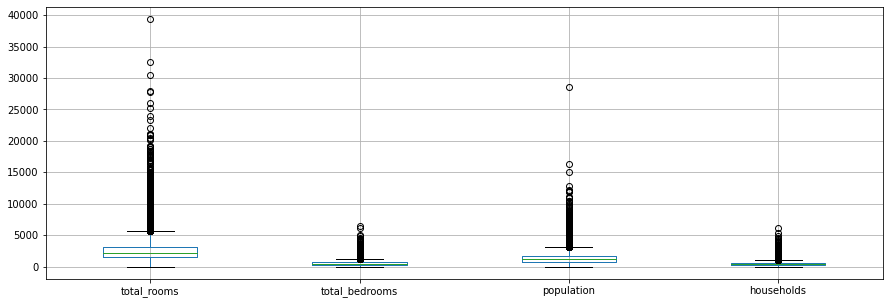

In [ ]:
train.loc[:, train.columns[(train.max() <= 50000) & (train.max() > 2000)].to_list()].boxplot(figsize=(15,5))

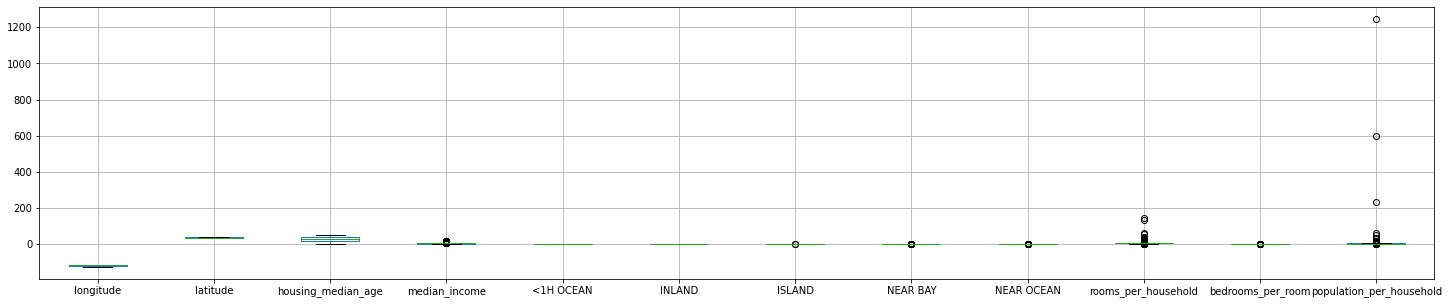

In [ ]:
train.loc[:, train.columns[(train.max() <= 2000)].to_list()].boxplot(figsize=(25,5))

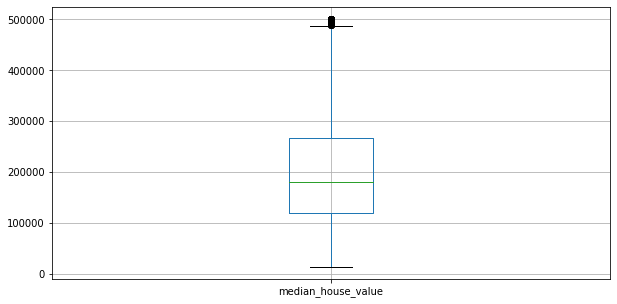

In [ ]:
train.loc[:, train.columns[(train.max() > 50000)].to_list()].boxplot(figsize=(10,5)) 

By looking at the boxplots, we can see that there are only a few true outliers, so those can probably be ignored.

What does the IQR think, especially since it relies on normalized distirbutions?

In [ ]:
train_q1 = train.quantile(0.25)
train_q3 = train.quantile(0.75)
train_overall_IQR = train_q3 - train_q1

((train < (train_q1 - 1.5 * train_overall_IQR)) | (train > (train_q3 + 1.5 * train_overall_IQR))).sum()

longitude                      0
latitude                       0
housing_median_age             0
total_rooms                  688
total_bedrooms               662
population                   620
households                   623
median_income                357
<1H OCEAN                      0
INLAND                         0
ISLAND                         2
NEAR BAY                    1175
NEAR OCEAN                  1329
rooms_per_household          261
bedrooms_per_room            341
population_per_household     347
median_house_value           532
dtype: int64

I chose not to do anything to the outliers, as editing them to be median values caused the distributions shown below to be changed, which in turn caused the RMSE to greatly increase.

##Is normalization or standardization needed?

I chose not to perform normalization or standardization, as the data does not contain normal distributions, and there are correlations in the data that must be preserved. See below.

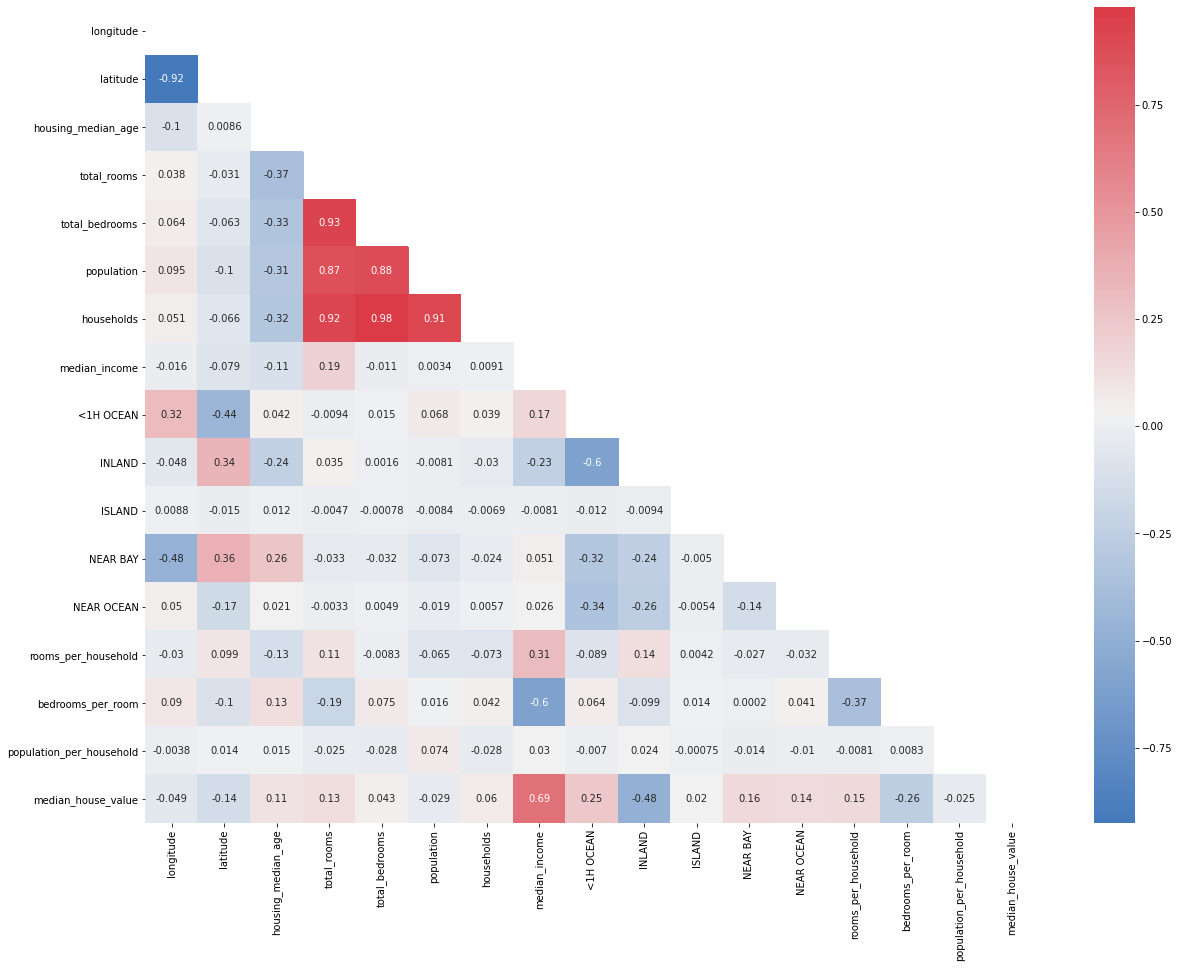

In [ ]:
corr = train.corr()

# Make a pretty colormap, ranging from red to blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Generate a mask to hide the values reflected above the diagonal.
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa701a3f110>,
      dtype=object)

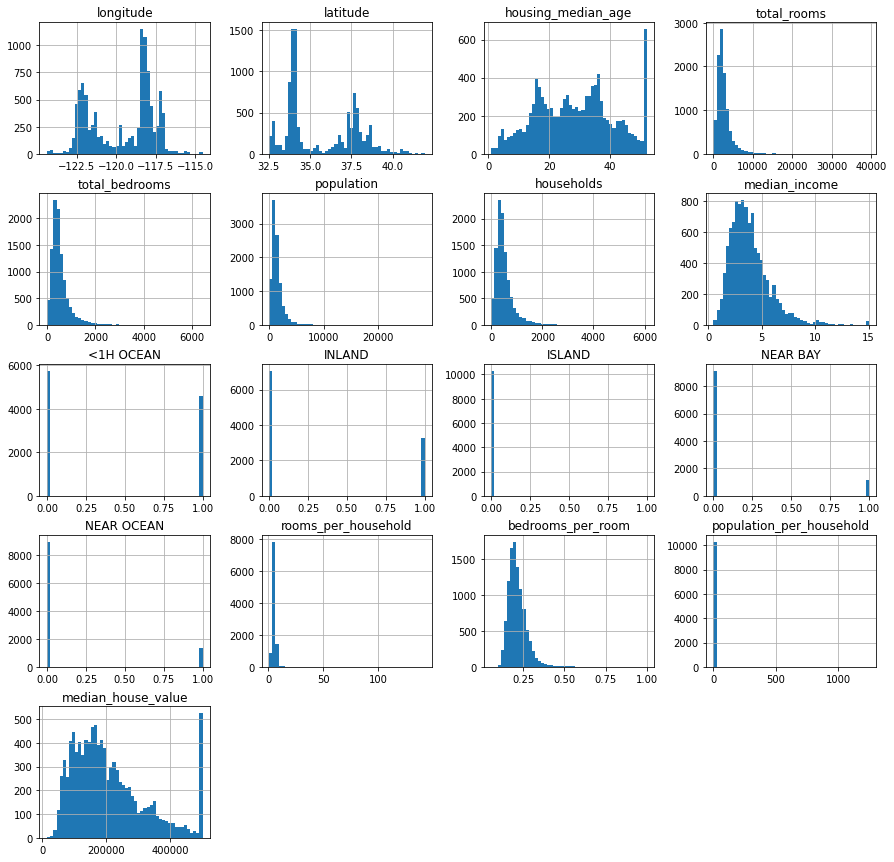

In [ ]:
train[train.columns].hist(bins=50,figsize=(15,15))

##Build the regression models:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X = train.loc[:, ~train.columns.isin(['id', 'median_house_value'])]
y = train['median_house_value']

seed = 11 #Fix seed for repeatability
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2,random_state=seed)
lin_reg_parameters = { 'fit_intercept': [True, False], }
lin_reg = GridSearchCV(LinearRegression(), lin_reg_parameters, cv=10, verbose=1)
lin_reg_model = lin_reg.fit(X=X_train, y=Y_train)
Y_pred = lin_reg.predict(X_val)

lin_val_rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

print("Linear Regression validation RMSE: ",lin_val_rmse)
print("Model: ",lin_reg_model)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression validation RMSE:  66468.97996188496
Model:  GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


In [ ]:
from sklearn.linear_model import Ridge

import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

seed = 11 #Fix seed for repeatability
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2,random_state=seed)
ridge_reg_parameters = { 'fit_intercept': [True, False], 
                      'normalize': [True],
                      'alpha': np.logspace(0,-9,50)}
ridge_reg = GridSearchCV(Ridge(), ridge_reg_parameters, cv=10, verbose=1)
ridge_reg_model = ridge_reg.fit(X=X_train, y=Y_train)
Y_pred = ridge_reg.predict(X_val)

ridge_val_rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

print("Ridge Regression validation RMSE: ",ridge_val_rmse)
print("Model: ",ridge_reg_model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Ridge Regression validation RMSE:  66468.33251715811
Model:  GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e+00, 6.55128557e-01, 4.29193426e-01, 2.81176870e-01,
       1.84206997e-01, 1.20679264e-01, 7.90604321e-02, 5.17947468e-02,
       3.3932217...
       1.32571137e-06, 8.68511374e-07, 5.68986603e-07, 3.72759372e-07,
       2.44205309e-07, 1.59985872e-07, 1.04811313e-07, 6.86648845e-08,
       4.49843267e-08, 2.94705170e-08, 1.93069773e-08, 1.26485522e-08,
       8.28642773e-09, 5.42867544e-09, 3.55648031e-09, 2.32995181e-09,
       1.52641797e-09, 1.00000000e-09]),
                         'fit_intercept': [True, False], 'norma

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.7s finished


In [ ]:
from sklearn.linear_model import Lasso

seed = 11 #Fix seed for repeatability
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2,random_state=seed)
lasso_reg_parameters = { 'fit_intercept': [True, False], 
                      'normalize': [True,False],
                      }
lasso_reg = GridSearchCV(Lasso(), lasso_reg_parameters, cv=10, verbose=1)
lasso_reg_model = lasso_reg.fit(X=X_train, y=Y_train)
Y_pred = lasso_reg.predict(X_val)

lasso_val_rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

print("Lasso Regression validation RMSE: ",lasso_val_rmse)
print("Model: ",lasso_reg_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Lasso Regression validation RMSE:  66485.63637953524
Model:  GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.8s finished


The model that worked best for me was the ridge regression model.

##Plot the sampling distributions for the RMSE for each model built:

In [ ]:
def find_best_train_test_split(X,y, model, name, splits,iters):
  train_ps = []
  train_f1 = []

  val_ps = []
  val_f1 = []

  print("Checking performance of {0}:".format(name), end='')

  for i in splits:

    #print("Checking split: ", i)
    print('|', end='')

    for j in range(iters):
      
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=i)

      y_pred = model.predict(X_train)
      train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
      
      train_ps.append(i)
      train_f1.append(train_rmse)

      y_pred = model.predict(X_val)
      val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))

      val_ps.append(i)
      val_f1.append(val_rmse)
  print()
  return pd.DataFrame({'tpct':val_ps, 'val_f1':val_f1, 'train_f1':train_f1})

def showSplitsGraph(X,y,model,name,splits,iters):
  ans = find_best_train_test_split(X,y, model, name, splits,iters)
  f, axs = plt.subplots(1,2,figsize=(10,6))
  fig = plt.gcf()
  model_name = name
  fig.suptitle(model_name)
  axs[0].set_title('Train F1')
  sns.boxplot(data=ans[ans['tpct'] > 0.01], x='tpct', y = 'train_f1', ax=axs[0])
  axs[1].set_title('Val F1')
  sns.boxplot(data=ans[ans['tpct'] > 0.01], x='tpct', y = 'val_f1', ax=axs[1])
  f.tight_layout()
  return ans

Checking performance of Linear Regression:||||||||||||
Checking performance of Ridge Regression:||||||||||||
Checking performance of Lasso Regression:||||||||||||


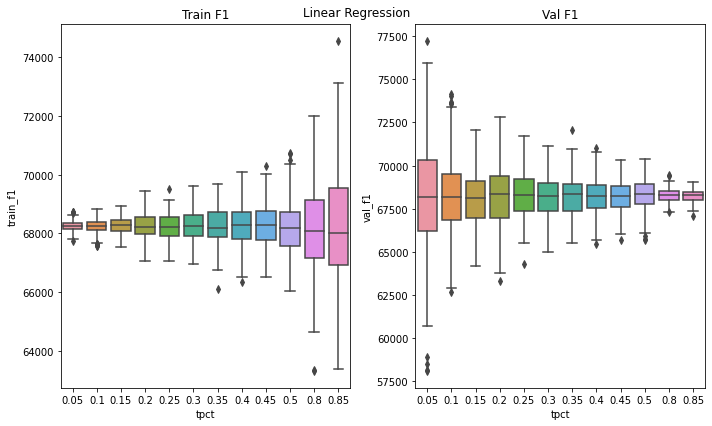

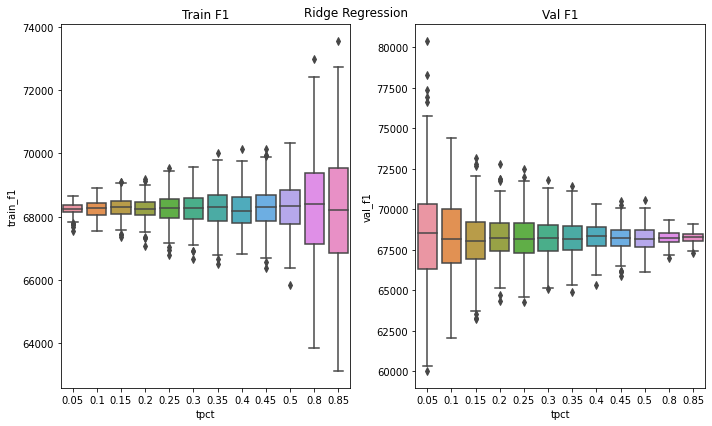

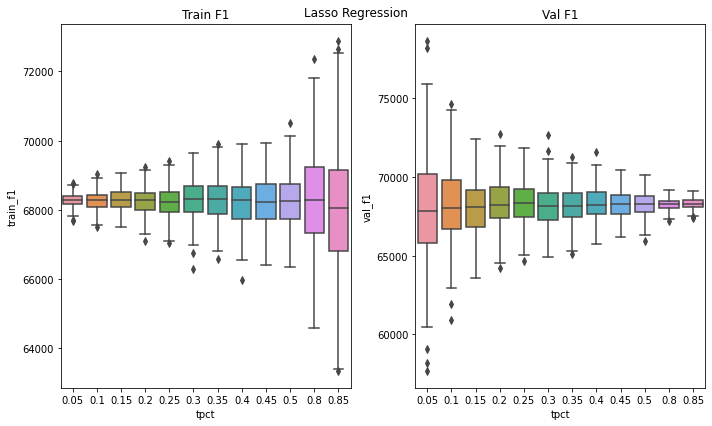

In [ ]:
tpct_ranges = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.8, 0.85]

models = [lin_reg_model, ridge_reg_model, lasso_reg_model]
names = ['Linear Regression','Ridge Regression','Lasso Regression']

for i in range(0,len(models)):
  model = models[i]
  name = names[i]
  showSplitsGraph(X,y,model,name,tpct_ranges,250)

The goal is for RMSE to be below 68592.3

##Apply the same preprocessing to the test data and then predict the target vector from the test data.

In [ ]:
test = original_test.copy().drop(columns=['id'])

prox_dummies_test = pd.get_dummies(test['ocean_proximity'])

test = test.drop(columns='ocean_proximity')

for col in prox_dummies:
  test[col] = prox_dummies_test[col].values

test['rooms_per_household'] = test['total_rooms']/test['households']
test['bedrooms_per_room'] = test['total_bedrooms']/test['total_rooms']
test['population_per_household'] = test['population']/test['households']

imputer = SimpleImputer(strategy='median')
new_test = pd.DataFrame(imputer.fit_transform(test))

new_test.columns = test.columns
new_test.index = test.index

test = new_test

pred = ridge_reg.predict(test)

It's inconvenient for multiple bad files to be downloaded when rerunning the notebook. Download is set to true when ready to submit.

In [ ]:
download = True

len(pred), len(test)

(10320, 10320)

##Package the test prediction, and turn it into a csv file. If we are downloading, do so.

In [ ]:
submission = pd.DataFrame({
    "id": original_test['id'],
    "median_house_value": pred
})

sub_name = 'submission-' + datetime.now().strftime("%H:%M:%S") + '.csv'

submission.to_csv(sub_name, index=False)

if download:
  files.download(sub_name)
  print('Created: ', sub_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created:  submission-03:29:49.csv


##Show off the submitted file.

In [ ]:
pd.set_option('display.max_rows', len(submission)+1)
submission

,id,median_house_value
0,0,152308.521249
1,1,259652.407999
2,2,145208.924794
3,3,166698.819413
4,4,182770.805091
5,5,306833.115551
6,6,146182.400358
7,7,114308.861019
8,8,249628.544061
9,9,92698.932001


File submitted with test RMSE of 67873.28366